# **CLUSTERING METHODS FOR LAGRANGIAN ANALYSIS**

### What do we mean by clustering?
In ocean Lagrangian analysis, clustering methods are used to group together particle or drifter trajectories that share similar characteristics in space, time, or dynamical behavior. The questions we try to answer is: 

**How do we classify a spatiotemporal distribution of trajectories?**

The choice of method depends on what your particles represent and whether you are interested in spatial aggregation (where particles cluster) or path similarity (how trajectories evolve). Several studies illustrate the diversity of clustering approaches in the fiedl of geophysical fluid dynamics:

*From simulated trajectories*
- Detection of Algulhas rings in the Southern Ocean [Wichmann, D., et al. (2021)](https://doi.org/10.5194/npg-28-43-2021)
- Identification of the main pathways of the Labrador Current [Jutras, M., Planat, N., Dufour, C. O., & Talbot, L. C. (2024)](https://doi.org/10.1029/2023MS003902)
- Classification of dispersion regimes from clustering of autocorrelation velocities [Lagomarsino-Oneto, D., De Leo, A., Stocchino, A., & Cucco, A. (2024).](https://doi.org/10.1029/2023GL107900)
- Theoretical study of inertial particle clustering dynamics in idealised flow [Bandopadhyay, T., Tomas-Gil, A., & Villafañe, L. (2025)](https://doi.org/10.1016/j.ijmultiphaseflow.2025.105313)

*From drifter data*
- Estimation of eddy diffusivities from clustering of surface drifter data [I. Koszalka, et al. (2011)](https://doi.org/10.1016/j.dsr.2011.01.007)
- Analysis of the inertial effects of different drifter shapes/size [Miron, P. et al. (2020)](https://doi.org/10.1029/2020GL089874 )

There are a wide variety of designed clustering techniques (see [Rasyid, L. A., and Andayani, S., (2018)](10.1088/1742-6596/1097/1/012082) for a review). 
The algorithms we will be using here are:
- [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): a spatial partitioning into K number of clusters by minising within-cluster variance (squared Euclidean distance)
- [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) ([Sander, J., et al. 1998](https://doi.org/10.1023/A:1009745219419)): a density-based algorithm that groups together points that are closely packed (points with many nearby neighbors), and marks as outliers points that lie alone in low-density regions. 
- [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) ([Ankerst, M., et al. 1999](https://doi.org/10.1145/304181.304187)): extension of DBSCAN algorithm that can handle clusters of varying densities.  

The notebook is organised as follows:
- Case 1: spatial clustering of simulated particle positions
- Case 2: 

### Import packages & data

In [3]:
import xarray as xr
import numpy as np
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN, KMeans
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean

dataset= xr.open_dataset('/Users/1614576/Downloads/toy_data_01.nc')
dataset

<xarray.Dataset> Size: 627kB
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 139kB ...
    time        (traj, obs) datetime64[ns] 139kB ...
    lat         (traj, obs) float32 70kB ...
    lon         (traj, obs) float32 70kB ...
    z           (traj, obs) float32 70kB ...
    U           (traj, obs) float32 70kB ...
    V           (traj, obs) float32 70kB ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

## **Case 1**: Spatial clustering of simulated particle positions
In this analysis, we capture a snapshot of the particle trajectories and use distance- and density-based clustering to uncover hidden patterns in their spatial distribution. This approach helps reveal **how particles are grouped by the flow field**.

### I. Selection of the snapshot 🔴

In [4]:
time_index=118
time= dataset.time.isel(obs=time_index).values[0]
ds=dataset.isel(obs=time_index)

### II. Define & apply clustering algorithms 🔴

In [5]:

clustering_dict={ 
    'K-means': {'algorithm': KMeans(n_clusters=10)},
    'DBSCAN':  {'algorithm': DBSCAN(eps=np.radians(1), min_samples=5,  metric='haversine', algorithm='ball_tree')},
    'OPTICS':  {'algorithm': OPTICS(min_samples= 10, metric='haversine', algorithm='ball_tree', max_eps=np.radians(2))}, 
}

💡 Look-up at the webiste of [Scikit learn package](https://scikit-learn.org/stable/api/sklearn.cluster.html) to understand the physical meaning of the *eps*, *min_samples*, and *max_eps* parameters

In [6]:
def cluster(ds, algorithm, algorithm_name):
    """
    Perform clustering on particle trajectories using a specified clustering algorithm.
    
    Parameters
    ----------
    ds : xarray.Dataset 
        dataset containing 'lon', 'lat', and 'traj' (trajectory index) variables.
    algorithm : clustering object
        initialized clustering algorithm (e.g., KMeans, DBSCAN, OPTICS) from scikit-learn.
    algorithm_name : str
        name of the algorithm ('KMeans', 'DBSCAN', 'OPTICS') to handle algorithm-specific outputs.
    
    Returns
    -------
    df_cluster : pd.DataFrame
        DataFrame with original trajectory points and clustering results including:
        - cluster_label: cluster assignment (-1 for noise in DBSCAN/OPTICS)
        - is_noise: boolean flag for noise points
        - reachability: OPTICS reachability distance or zeros for other algorithms
        - ordering: OPTICS ordering of points or zeros for others
        - core_distances: OPTICS core distances or zeros for others
    """
    
    # convert longitude and latitude to radians and stack into Nx2 array for clustering
    points = np.column_stack([np.radians(ds.lon.values), np.radians(ds.lat.values)])
    
    # fit the clustering algorithm to the points
    clustering = algorithm.fit(points)
    
    # get cluster labels assigned by the algorithm
    labels = clustering.labels_
    
    # ensure noise points are labeled as -1, otherwise keep the cluster label
    unique_labels = np.where(labels == -1, -1, labels)

    # algorithm-specific handling for OPTICS
    if algorithm_name == 'OPTICS':
        # initialize reachability array with NaNs
        reachability_values = np.full(len(ds.lon.values), np.nan)
        # fill reachability in the order determined by OPTICS
        reachability_values[clustering.ordering_] = clustering.reachability_[clustering.ordering_]

        # initialize ordering array with -1
        ordering_values = np.full(len(ds.lon.values), -1)
        # store the position in the OPTICS ordering for each original point
        for order_pos, orig_idx in enumerate(clustering.ordering_):
            ordering_values[orig_idx] = order_pos
            
        # get core distances from OPTICS
        core_values = clustering.core_distances_
        
    else:
        # for non-OPTICS algorithms, reachability, ordering, and core distances are not defined
        reachability_values = np.full_like(unique_labels, 0)
        ordering_values = np.full_like(unique_labels, 0)
        core_values = np.full_like(unique_labels, 0)
    
    # Create a DataFrame with clustering results and original trajectory info
    df_cluster = pd.DataFrame({
        'traj_index': ds.traj.values,       
        'lon': ds.lon.values,                
        'lat': ds.lat.values,                
        'cluster_label': unique_labels,      
        'is_noise': (labels == -1),         
        'reachability': reachability_values, 
        'ordering': ordering_values,        
        'core_distances': core_values,       
    })
    
    return df_cluster

In [7]:
#execute clustering for all algorithms
for clustering_method in tqdm(clustering_dict):
    algorithm= clustering_dict[clustering_method]['algorithm']
    clustering_dict[clustering_method]['result']= cluster(ds, algorithm, clustering_method)

100%|██████████| 3/3 [00:00<00:00, 57.73it/s]


### III. Visualise results 🔴

  0%|          | 0/3 [00:00<?, ?it/s]

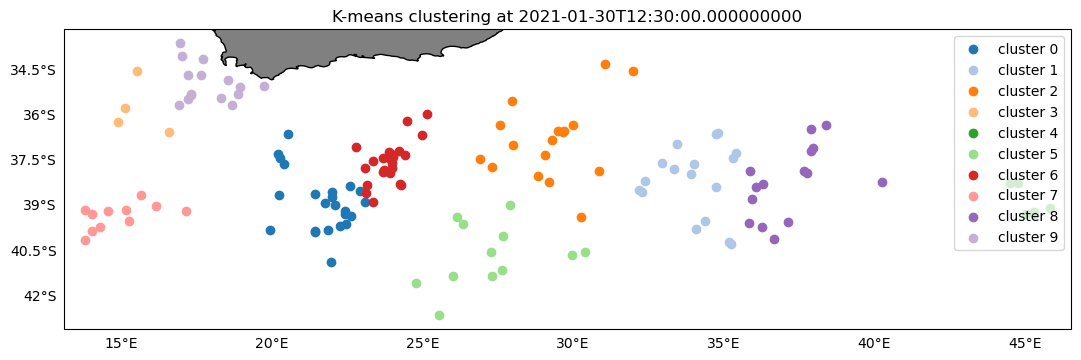

 33%|███▎      | 1/3 [00:00<00:01,  1.03it/s]

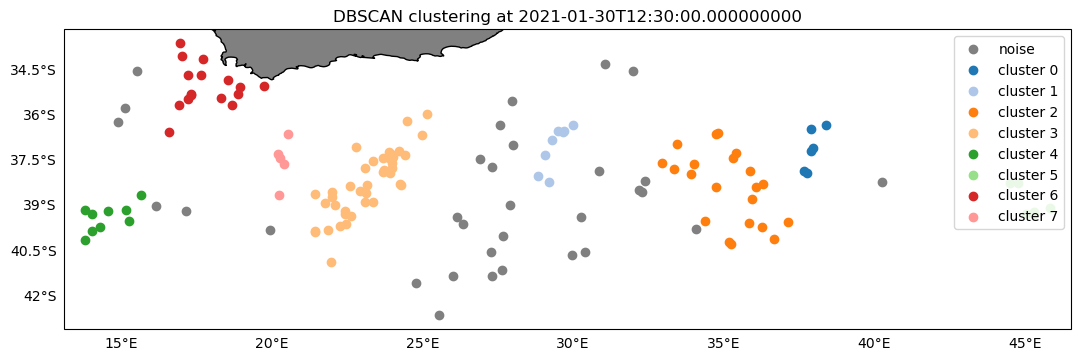

 67%|██████▋   | 2/3 [00:01<00:00,  2.07it/s]

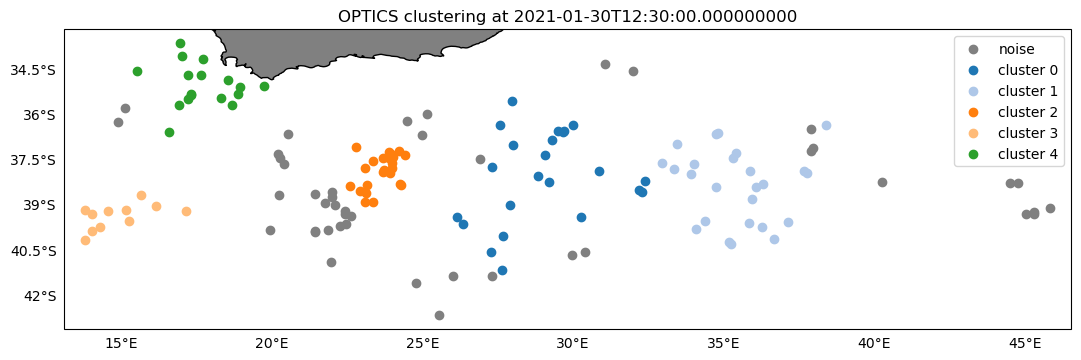

100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


In [8]:
for clustering_method in tqdm(clustering_dict):
    df=clustering_dict[clustering_method]['result']

    fig=plt.figure(figsize=(13,6)) 
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0.0))

    #plot coastlines
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.LAND, facecolor='grey')

    #draw grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.right_labels = False
    gl.top_labels = False


    #plot the noise points
    if -1 in np.unique(df['cluster_label']):
        noise_df= df[df['cluster_label']==-1]
        label_df=df[df['cluster_label']!=-1]
        ax.scatter(noise_df['lon'], noise_df['lat'], c='grey', label='noise')
    
    else:
        label_df= df

    colors = mpl.colormaps['tab20'].colors

    #plot clustered points
    for i, elem in enumerate(np.unique(label_df['cluster_label'])):
        a=label_df[label_df['cluster_label']==elem]
        ax.scatter(a['lon'], a['lat'], color=colors[i % len(colors)], label=f'cluster {elem}')
    

    if 'centroids' in clustering_dict[clustering_method].keys():
        ax.scatter(clustering_dict[clustering_method]['centroids']['lon_mean'], clustering_dict[clustering_method]['centroids']['lat_mean'], marker='x', s=35, color='black', label='centroids')

    plt.legend()
    #ax.set_xlim(11, 55)
    ax.set_xlim(df['lon'].min()-0.7, df['lon'].max()+0.7)
    plt.title(f'{clustering_method} clustering at {time}')
    plt.show()

🚀 **CHALLENGE**: Try to calcualte the centre of mass of each cluster & add it to the plots above!

In [78]:
####SOLUTION
for clustering_method in tqdm(clustering_dict):
    df = clustering_dict[clustering_method]['result']
    
    # select only points that belong to clusters (exclude noise)
    label_df = df[df['cluster_label'] != -1]
    
    # compute cluster centroids and cluster size
    centroids = (
        label_df.groupby('cluster_label')
        .agg(
            lon_mean=('lon', 'mean'),
            lat_mean=('lat', 'mean'),
            n_points=('lon', 'size')  # number of points in cluster
        )
        .reset_index()
    )
    
    # add method name column (optional)
    centroids['method'] = clustering_method
    
    # Save the centroids DataFrame into clustering_dict under 'centroids'
    clustering_dict[clustering_method]['centroids'] = centroids

100%|██████████| 3/3 [00:00<00:00, 249.57it/s]


💡 *What to do now?*
- Experiment with changing the parameters defining the algorithms & observe the differences
- Change the time index & observe how the results change

### IV. Statistical analysis of clusters 🔴
In order to compare the results from different clustering algorithms, we can derive the following statistical properties:
    
- Number of clusters
- Number of points per cluster
- Within-cluster concentration[points/$km^2$]

In [110]:
def calculate_number_clusters(clustering_dict):
    number_clusters={}
    for clustering_method in clustering_dict:
        number_clusters[clustering_method]=len(np.unique(clustering_dict[clustering_method]['result']['cluster_label']))
    return number_clusters

calculate_number_clusters(clustering_dict)

{'K-means': 10, 'DBSCAN': 9, 'OPTICS': 6}

🚀 Your turn! Create functions to calculate the number of points per cluster for each algorithm & calculate the concentration of each cluster

 *Hint:* to calculate the area covered by points, use [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html) 

Text(0.5, 0, 'Clustering algorithms')

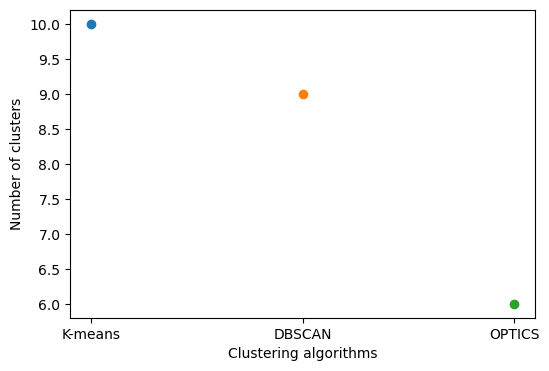

In [108]:
# plot the resutls
fig, ax = plt.subplots(figsize=(6, 4))

number_clusters=calculate_number_clusters(clustering_dict)
for method in number_clusters:
    plt.scatter(method, number_clusters[method])

plt.ylabel('Number of clusters')
plt.xlabel('Clustering algorithms')


🚀 Choose two options to visualise your results of points per cluster and concentration of each cluster:

- Make a box plot with the mean & std property per algorithm
- Make a histogram per cluster with the distribution points per cluster/ concentration

### *Want another **challenge** ?* 🔴
- Try using this other dataset: *'toy_data_02.zarr'*

    *Hint:* make the following changes to the algorithms
    - DBSCAN(eps=np.radians(0.2), min_samples=30,  metric='haversine', algorithm='ball_tree')
    - OPTICS(min_samples= 10, metric='haversine', algorithm='ball_tree', max_eps=np.radians(2)) 

- Take a look at other [clustering algorithms included in Scikit learn package](https://scikit-learn.org/stable/api/sklearn.cluster.html) & try experimenting with other algorithms!
